In [1]:
import cv2
import yaml
import itertools
import numpy as np 
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split

from yolov2.utils.painter import draw_boxes
from yolov2.utils.parser import parse_inputs, parse_label_map

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
training_path ='../pascal/training_data.csv'
config_file   = 'config.yml'

In [3]:
with open(config_file, 'r') as stream:
    config = yaml.load(stream)
    
anchors = np.array(config['anchors']) * (config['model']['image_size'] / 608.)

num_anchors = config['model']['num_anchors']
upper_pts = anchors - anchors / 2.0
lower_pts = anchors + anchors / 2.0

# for generating ground truth laters
anchors_boxes = np.concatenate([upper_pts, lower_pts], axis=-1).astype(np.float32)[[1, 0, 3, 2]]
print(anchors_boxes)

num_classes = 20
shrink_factor = config['model']['shrink_factor']


label_dict = parse_label_map(config['label_map'])
inv_map = {v: k for k, v in label_dict.iteritems()}
inputs, labels = parse_inputs(training_path, inv_map)


# Create 10-fold split
x_train, x_val = train_test_split(inputs, test_size=0.2)
y_train = [labels[k] for k in x_train]
y_val   = [labels[k] for k in x_val]

print("Number of training samples: {} || {}".format(len(x_train), len(y_train)))
print("Number of validation samples: {} || {}".format(len(x_val), len(y_val)))
print("Anchors:\n {}".format(anchors))

[[ 0.49327895  0.54277104  1.47983682  1.62831318]
 [ 0.15071842  0.17825921  0.45215526  0.53477764]
 [ 2.07442641  0.92836314  6.223279    2.78508949]
 [ 0.8785342   1.44061577  2.63560271  4.32184744]]
Number of training samples: 12064 || 12064
Number of validation samples: 3016 || 3016
Anchors:
 [[ 0.30143684  0.35651842]
 [ 0.98655789  1.08554211]
 [ 1.75706842  2.88123158]
 [ 4.14885263  1.85672632]
 [ 5.14237895  4.82541053]]


In [4]:
def iou(boxes_list1, boxes_list2, scope=None):
    with tf.name_scope(scope, 'IOU'):
        areas1        = area(boxes_list1)
        areas2        = area(boxes_list2)
        intersections = intersection(boxes_list1, boxes_list2)

        unions = (tf.expand_dims(areas1, 1) +
                  tf.expand_dims(areas2, 0) - intersections)

    return tf.where(tf.equal(intersections, 0.0),
                    tf.zeros_like(intersections),
                    tf.truediv(intersections, unions))


def area(boxes, scope=None):
    with tf.name_scope(scope, 'Area'):
        y_min, x_min, y_max, x_max = tf.split(value=boxes, num_or_size_splits=4, axis=-1)
        return tf.squeeze((y_max - y_min) * (x_max - x_min), [1])


def intersection(boxes_list1, boxes_list2, scope=None):
    with tf.name_scope(scope, 'Intersection'):
        y_min1, x_min1, y_max1, x_max1 = tf.split(value=boxes_list1, num_or_size_splits=4, axis=-1)
        y_min2, x_min2, y_max2, x_max2 = tf.split(value=boxes_list2, num_or_size_splits=4, axis=-1)

        all_pairs_min_ymax = tf.minimum(y_max1, tf.transpose(y_max2))
        all_pairs_max_ymin = tf.maximum(y_min1, tf.transpose(y_min2))

        intersect_heights = tf.maximum(0.0, all_pairs_min_ymax - all_pairs_max_ymin)
        all_pairs_min_xmax = tf.minimum(x_max1, tf.transpose(x_max2))
        all_pairs_max_xmin = tf.maximum(x_min1, tf.transpose(x_min2))

        intersect_widths = tf.maximum(0.0, all_pairs_min_xmax - all_pairs_max_xmin)

    return intersect_heights * intersect_widths

In [217]:
def data_generator(images, labels, img_size, shuffle=True, batch_size=4):
    dataset   = create_tfdata(images, labels, img_size, shuffle, batch_size)
    iterator   = dataset.make_one_shot_iterator()
    next_batch = iterator.get_next()
    while True:
        yield K.get_session().run(next_batch)

def create_tfdata(images, labels, img_size, shuffle=True, batch_size=4):
    
    def read_img_file(filename, label):
        image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape
        image = cv2.resize(image, (img_size, img_size))
        
        # @BUG : boxess
        # A label is consist of [y1, x1, y1, x1, class_idx]
        label  = np.reshape(label, (-1, 5))
   
        # Convert coordinates to relative values
        boxes  = label[..., 0:4] / np.array([height, width , height , width], np.float32)
        
        # Adjust boxes to correct ratio (due to distorted image)
        w_ratio = width / float(height) if width < height else 1.0
        h_ratio = height / float(width) if width < height else 1.0 
        boxes   = boxes * np.array([h_ratio, w_ratio, h_ratio, w_ratio], np.float32)
        
        label  = np.concatenate([boxes, np.expand_dims(label[...,-1],1)], axis=-1)
        return image, label

    def process_label(img, label):
        
        # Generate feature map using scater_nd
        boxes, classes = tf.split(label, [4, 1], 1)
        
        # 2. Construct output feature
        objectness = tf.ones_like(classes)
        one_hot    = tf.one_hot(tf.cast(tf.squeeze(classes, axis=1), tf.uint8), num_classes)
        values     = tf.concat([boxes, objectness, one_hot], axis=1)
                
         # 1. Determine indices (where to put gtruths in the feature map)
        # two ground truths may be in same cell, 
        # so we need to calculate the IoU
        iou_scores   = iou(boxes, anchors_boxes)
        cell_indices = tf.cast(tf.argmax(iou_scores, axis=1), tf.int32)
        cell_indices = tf.expand_dims(cell_indices, axis=-1)
        
        area     = boxes[...,2:4] - boxes[..., 0:2]
        centroid = boxes[..., 0:2] + (area / 2.0)    
        indices  = tf.cast(tf.floor(centroid * (img_size / shrink_factor)), tf.int32)
        indices   = tf.concat([indices, cell_indices], axis=-1)
        
        # 3. Create feature map
        # https://www.tensorflow.org/api_docs/python/tf/scatter_nd
        feature_map = tf.scatter_nd(indices, values, shape= [ 10, 10 ,5, 5 + num_classes])
        
        return img, feature_map

    # a hack to handle list with different element size.
    dataset = tf.data.Dataset.from_generator(lambda: itertools.izip_longest(images, labels),
                                             (tf.string, tf.float32),
                                             (tf.TensorShape([]), tf.TensorShape([None])))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)
        
    dataset = dataset.map(lambda filename, label:
                          tuple(tf.py_func(read_img_file,
                                           [filename, label],
                                           [tf.uint8, label.dtype])))
    dataset = dataset.map(process_label)
    dataset = dataset.batch(batch_size)
    
    return dataset
    
val_gen = data_generator(x_val,  y_val,config['model']['image_size'], batch_size=16)

In [218]:
images,  values = val_gen.next()

print(images.shape)

(16, 320, 320, 3)


In [219]:
print(values.shape)

(16, 10, 10, 5, 25)


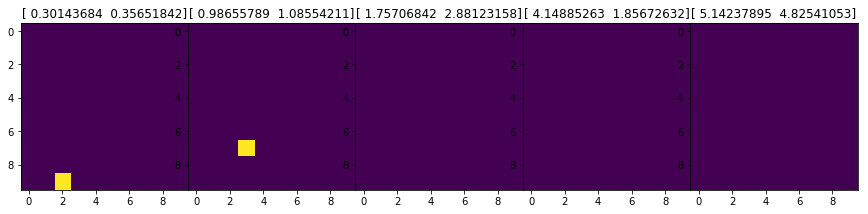

In [228]:
# gt_boxes = gt_boxes * np.array([h, w, h, w]) 
# gt_classes = np.squeeze(gt_classes, 1)

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

a = values[8]
for cell in range(a.shape[-2]):
    heatmap = np.sum(a[:, :, cell, :], axis=-1)
    axs[cell].imshow(heatmap)
    axs[cell].set_title(anchors[cell])

[[5 5 0]
 [7 6 0]
 [6 3 1]]
[[  47.78666496   14.72000003  320.          320.        ]
 [ 157.01333046   97.91999817  320.          320.        ]
 [  75.09333134    1.28000006  320.          212.47999191]]


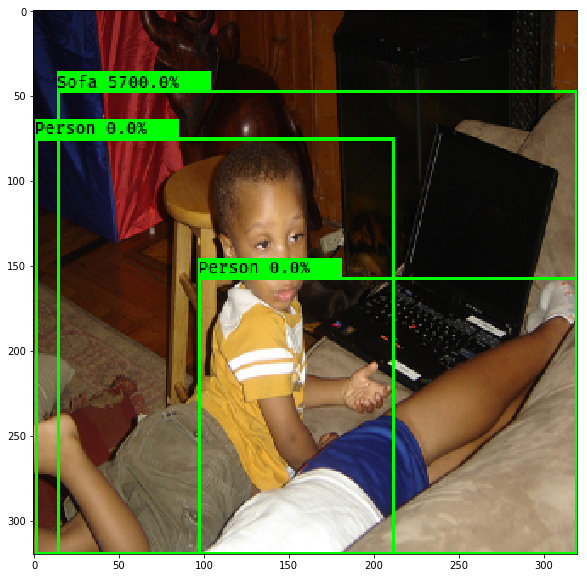

In [172]:
h, w, _ = images.shape
print(indices)
print(gt_boxes)
frame = draw_boxes(images,  gt_boxes, [label_dict[i] for i in gt_classes], gt_classes)
plt.figure(figsize=(10, 10))
_ = plt.imshow(frame)

In [ ]:
idx   = 0 
image = images[idx]
h,w, _ = image.shape
gt_boxes   = labels[idx][..., 0:4]
gt_classes = labels[idx][...,-1]

print(gt_classes)
print(gt_boxes)